

## 1. Transformada Discreta de Fourier (DFT)

A **Transformada Discreta de Fourier (DFT)** é uma ferramenta fundamental no processamento digital de sinais, permitindo a análise espectral de sinais discretos de duração finita. Segundo Diniz et al., a DFT mapeia uma sequência de $N$ amostras no domínio do tempo, $x(n)$, para uma sequência de $N$ coeficientes no domínio da frequência, $X(k)$.

A equação de análise (DFT direta) é definida como:

$$
X(k) = \sum_{n=0}^{N-1} x(n) W_N^{kn}, \quad \text{para } 0 \le k \le N-1
$$

Onde:
- **$x(n)$:** Amostra do sinal no tempo discreto.
- **$X(k)$:** Coeficiente da DFT na frequência discreta $k$.
- **$W_N$:** O núcleo da transformação, conhecido como **fator de torção** (ou *twiddle factor*).

---

## 2. O Método Matricial (DFT Matricial)

No livro de Diniz, a ênfase na implementação matricial surge da observação de que a somatória da DFT é uma operação linear. Para uma sequência de comprimento $N$, a DFT pode ser expressa de forma compacta utilizando álgebra linear.

Definindo os vetores coluna para o sinal de entrada $\mathbf{x}$ e para o espectro de saída $\mathbf{X}$:

$$
\mathbf{x} = [x(0), x(1), \dots, x(N-1)]^T
$$
$$
\mathbf{X} = [X(0), X(1), \dots, X(N-1)]^T
$$

A relação entre eles é dada pela equação matricial:

$$
\mathbf{X} = \mathbf{W}_N \mathbf{x}
$$

### 2.1 A Matriz da DFT ($\mathbf{W}_N$)

A matriz de transformação $\mathbf{W}_N$, de dimensão $N \times N$, contém todos os termos exponenciais complexos necessários para o cálculo. O elemento na linha $k$ e coluna $n$ da matriz é definido como:

$$
[\mathbf{W}_N]_{kn} = W_N^{kn} = e^{-j \frac{2\pi}{N} kn}
$$

Expandindo a matriz, temos a estrutura completa utilizada no algoritmo matricial:

$$
\mathbf{W}_N =
\begin{bmatrix}
W_N^0 & W_N^0 & W_N^0 & \cdots & W_N^0 \\
W_N^0 & W_N^1 & W_N^2 & \cdots & W_N^{N-1} \\
W_N^0 & W_N^2 & W_N^4 & \cdots & W_N^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
W_N^0 & W_N^{N-1} & W_N^{2(N-1)} & \cdots & W_N^{(N-1)(N-1)}
\end{bmatrix}
$$

**Propriedades Importantes da Matriz:**
* **Simetria:** A matriz $\mathbf{W}_N$ é simétrica, isto é, $\mathbf{W}_N^T = \mathbf{W}_N$.
* **Inversa:** A transformada inversa pode ser calculada usando a propriedade de que $\mathbf{W}_N^{-1} = \frac{1}{N} \mathbf{W}_N^*$, onde $*$ denota o conjugado complexo.

### 2.2 Complexidade e Desempenho (Análise do Livro)

A implementação direta da equação $\mathbf{X} = \mathbf{W}_N \mathbf{x}$ revela o custo computacional do método matricial:

* **Multiplicações Complexas:** A multiplicação de uma matriz $N \times N$ por um vetor $N \times 1$ requer $N^2$ multiplicações.
* **Adições Complexas:** Requer $N(N-1)$ adições.

Segundo Diniz, "a complexidade da DFT cresce com o quadrado do comprimento do sinal". Para sinais longos, esse crescimento quadrático ($O(N^2)$) torna o método matricial impraticável em tempo real, limitando severamente seu uso prático sem algoritmos de otimização.

---

## 3. Comparação com a FFT

Para mitigar o problema da complexidade $N^2$, utiliza-se a **Transformada Rápida de Fourier (FFT)**. O livro destaca o algoritmo de *Cooley-Tukey* (decimação no tempo ou na frequência) como a solução padrão.

### Diferença de Desempenho

A FFT explora a simetria e a periodicidade dos fatores $W_N^{kn}$ para decompor a DFT de tamanho $N$ em DFTs menores. A complexidade resultante é proporcional a:

$$
\text{Complexidade FFT} \approx N \log_2 N
$$

A disparidade de desempenho citada na literatura (Diniz et al.) é ilustrada pela razão de eficiência:

| Tamanho $N$ | Operações DFT Matricial ($N^2$) | Operações FFT ($N \log_2 N$) | Redução de Esforço |
| :---: | :---: | :---: | :---: |
| **64** | 4.096 | 384 | ~10x |
| **1024** | 1.048.576 | 10.240 | ~100x |

[cite_start]O gráfico gerado pelo código `tempo_dft_vs_fft_pt.py` confirmará visualmente esta teoria: a curva da DFT Matricial crescerá exponencialmente (parábola), enquanto a da FFT permanecerá quase linear (linear-logarítmica), comprovando que a FFT é indispensável para aplicações como processamento de áudio e imagens onde $N$ é grande[cite: 1577].

###  Detalhes da Implementação Matricial

A função `dft_matricial_completa` abaixo realiza dois passos críticos descritos na teoria:

1.  **Construção do Kernel (Matriz $\mathbf{W}$):**
    Em vez de usar laços `for` lentos, utilizamos o conceito de *broadcasting* do NumPy. Criamos um vetor linha $n$ e um vetor coluna $k$. A operação `k * n` gera instantaneamente uma matriz $N \times N$ com todos os produtos de índices necessários para o expoente $e^{-j \frac{2\pi k n}{N}}$.

2.  **Transformação Linear:**
    A aplicação da DFT é reduzida a uma única operação de álgebra linear: `W @ x`.

> **Nota:** Nesta versão, o tempo de **alocação e cálculo da matriz $\mathbf{W}$** está incluído na medição. Isso é importante pois, para $N$ grandes, o simples ato de criar uma matriz $N^2$ na memória consome um tempo significativo, revelando o custo real do método $O(N^2)$.

In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt

def dft_matricial(x, unitaria=False):
    """
    Método Matricial COMPLETO:
    1. Aloca e calcula a matriz W (N^2 exponenciais).
    2. Realiza o produto matricial W @ x.
    """
    N = len(x)
    
    # 1. Criação da Matriz (O custo é incluído na medição!)
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)
    
    if unitaria:
        W = W / np.sqrt(N)
        
    # 2. Multiplicação O(N^2)
    return W @ x

###  Detalhes da Implementação Iterativa (Soma Direta)

A função `dft_iterativa` traduz literalmente a equação do somatório:

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j \frac{2\pi k n}{N}}$$

Nesta abordagem:
* Utilizamos dois laços `for` aninhados: o externo percorre as frequências $k$ e o interno percorre o tempo $n$.
* **Por que é lenta?** O Python é uma linguagem interpretada. O *overhead* de verificar tipos e gerenciar a memória a cada iteração do loop (milhões de vezes para $N$ grande) torna esta função ordens de magnitude mais lenta que as versões vetorizadas em C/Fortran (como o NumPy). Ela serve aqui estritamente para fins de **comparação didática**.
$$

In [14]:
def dft_iterativa(x):
    """
    Implementação da DFT com laços for explícitos.
    Extremamente lenta em Python puro, mas didática.
    """
    N = len(x)
    X = np.zeros(N, dtype=complex)
    
    # Loop duplo: para cada frequência k, somamos todos os tempos n
    for k in range(N):
        soma = 0
        for n in range(N):
            soma += x[n] * np.exp(-2j * np.pi * k * n / N)
        X[k] = soma / np.sqrt(N) # Normalização (opcional)
        
    return X

### Metodologia de Medição de Desempenho

Para garantir uma comparação justa entre algoritmos tão distintos, implementamos uma infraestrutura de teste robusta:

1.  **Função de Alta Ordem (`tempo_execucao`):**
    Criamos uma função genérica que aceita *outra função* como argumento (`func`). Isso nos permite usar exatamente o mesmo cronômetro (`time.perf_counter`) para todos os métodos.

2.  **Média de Execuções:**
    Como o sistema operacional pode ter flutuações de desempenho, executamos cada algoritmo múltiplas vezes (`n_repeticoes`) e tomamos a média.

3.  **Variabilidade de $N$:**
    Testamos tamanhos de vetor em potências de 2 (de 16 a 1024). Note que limitamos o teste da **DFT Iterativa** até $N=512$, pois acima disso o tempo de execução se torna proibitivo para uma demonstração interativa.

In [15]:
def tempo_execucao(func, args=(), n_repeticoes=3):
    """Mede tempo médio de execução de qualquer função passada como argumento."""
    # Aquecimento simples se não for a iterativa (que é muito lenta)
    if func != dft_iterativa:
        func(*args)
        
    tempos = []
    for _ in range(n_repeticoes):
        t0 = time.perf_counter()
        func(*args) # Executa a função recebida
        t1 = time.perf_counter()
        tempos.append(t1 - t0)
    return float(np.mean(tempos))

def medir_tempos(Ns):
    t_mat = []
    t_iter = []
    t_fft = []

    print(f"{'N':<6} | {'Matricial (Full)':<18} | {'Iterativa (Loops)':<18} | {'FFT (NumPy)':<15}")
    print("-" * 65)

    for N in Ns:
        x = np.random.randn(N) + 0j
        
        # 1. DFT Matricial
        # Repetimos mais vezes para N pequeno para ter precisão
        reps = 10 if N < 256 else 3
        tm = tempo_execucao(dft_matricial, args=(x,), n_repeticoes=reps)
        t_mat.append(tm)

        # 2. DFT Iterativa (Limitada a N=512 para não travar)
        if N <= 512: 
            reps_iter = 3 if N < 128 else 1
            ti = tempo_execucao(dft_iterativa, args=(x,), n_repeticoes=reps_iter)
        else:
            ti = None
        t_iter.append(ti)

        # 3. FFT (NumPy) - Algoritmo O(N log N)
        tf = tempo_execucao(np.fft.fft, args=(x,), n_repeticoes=20)
        t_fft.append(tf)

        t_iter_str = f"{ti:.5f}s" if ti is not None else "---"
        print(f"{N:<6} | {tm:.5f}s          | {t_iter_str}          | {tf:.5f}s")

    return np.array(t_mat), t_iter, np.array(t_fft)

###  Análise Gráfica dos Resultados

A função de plotagem gera duas visualizações complementares para validar a teoria de Diniz:

1.  **Escala Linear (Tempo Real):**
    * Mostra o impacto prático. Espera-se que a linha da **DFT Matricial** dispare para cima (formato parabólico), enquanto a **FFT** permanece "colada" ao eixo zero, demonstrando sua viabilidade para tempo real.

2.  **Escala Log-Log (Ordem de Complexidade):**
    * Neste gráfico, funções de potência $N^p$ aparecem como retas.
    * A inclinação (slope) da reta indica o expoente $p$.
    * **DFT Matricial e Iterativa:** Devem apresentar inclinação $\approx 2$ (indicando $O(N^2)$).
    * **FFT:** Deve apresentar inclinação $\approx 1$ (indicando $O(N \log N)$).

Esta visualização confirma que a vantagem da FFT não é apenas uma constante de otimização, mas uma **classe de complexidade inferior**.

N      | Matricial (Full)   | Iterativa (Loops)  | FFT (NumPy)    
-----------------------------------------------------------------
16     | 0.00001s          | 0.00019s          | 0.00000s
32     | 0.00002s          | 0.00074s          | 0.00000s
64     | 0.00009s          | 0.00290s          | 0.00000s
128    | 0.00031s          | 0.01146s          | 0.00000s
256    | 0.00172s          | 0.04580s          | 0.00001s
512    | 0.00567s          | 0.18712s          | 0.00001s
1024   | 0.02245s          | ---          | 0.00001s


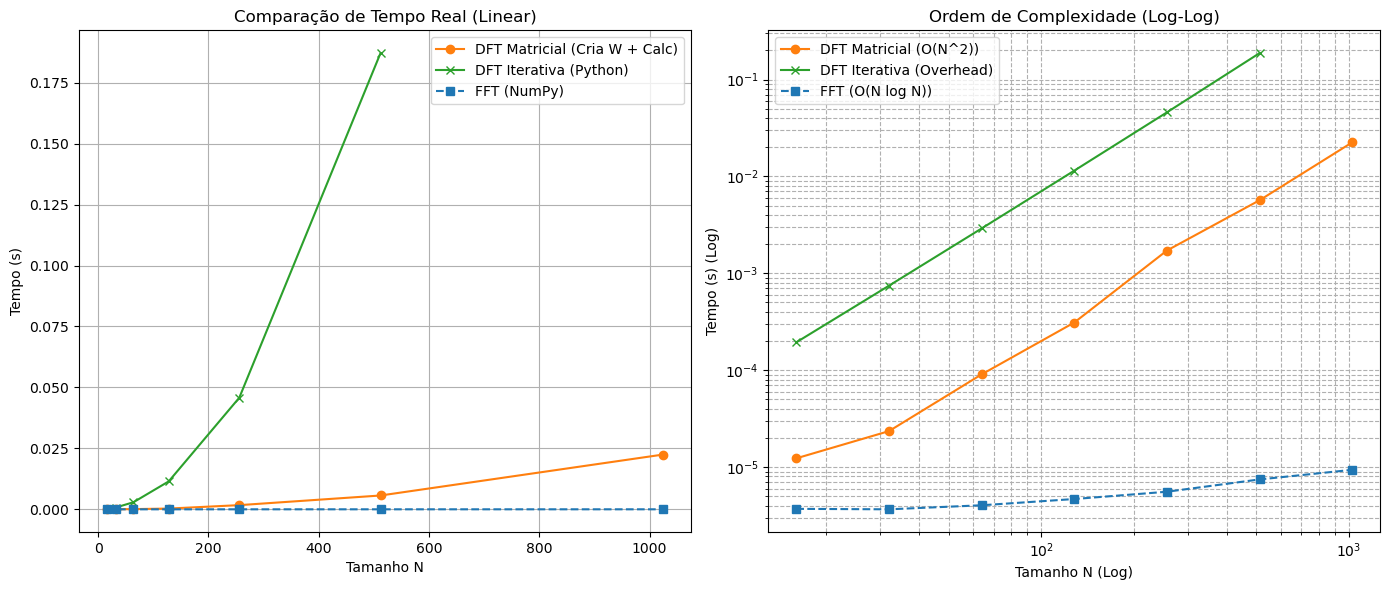

In [16]:
def plotar_resultados(Ns, t_mat, t_iter, t_fft):
    # Filtra dados da iterativa para plotagem
    mask_iter = [t is not None for t in t_iter]
    Ns_iter = [n for n, m in zip(Ns, mask_iter) if m]
    t_iter_clean = [t for t in t_iter if t is not None]

    plt.figure(figsize=(14, 6))

    # Gráfico 1: Linear
    plt.subplot(1, 2, 1)
    plt.plot(Ns, t_mat, 'o-', label='DFT Matricial (Cria W + Calc)', color='tab:orange')
    plt.plot(Ns_iter, t_iter_clean, 'x-', label='DFT Iterativa (Python)', color='tab:green')
    plt.plot(Ns, t_fft, 's--', label='FFT (NumPy)', color='tab:blue')
    plt.xlabel('Tamanho N')
    plt.ylabel('Tempo (s)')
    plt.title('Comparação de Tempo Real (Linear)')
    plt.legend()
    plt.grid(True)

    # Gráfico 2: Log-Log
    plt.subplot(1, 2, 2)
    plt.loglog(Ns, t_mat, 'o-', label='DFT Matricial (O(N^2))', color='tab:orange')
    plt.loglog(Ns_iter, t_iter_clean, 'x-', label='DFT Iterativa (Overhead)', color='tab:green')
    plt.loglog(Ns, t_fft, 's--', label='FFT (O(N log N))', color='tab:blue')
    
    plt.xlabel('Tamanho N (Log)')
    plt.ylabel('Tempo (s) (Log)')
    plt.title('Ordem de Complexidade (Log-Log)')
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

# --- Execução Principal ---
# Definimos Ns até 1024 para visualização clara sem demorar excessivamente
Ns = [16, 32, 64, 128, 256, 512, 1024] 
    
t_mat, t_iter, t_fft = medir_tempos(Ns)
plotar_resultados(Ns, t_mat, t_iter, t_fft)